# Paper figures

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import Tensor
from typing import Any

import qkernels
import plot_utils

plot_utils.configure()

Recommend (Ubuntu):
  sudo apt-get install cm-super dvipng fonts-cmu texlive-latex-extra


## Quoted calculations

In [2]:
l40s_bw = 864e9
l40s_bf16_flops = 362e12
print("L40S hardware intensity", l40s_bf16_flops/ l40s_bw)
print("m=400, k=n=large operational intensity", 1/(1/400) * (2/2))
print("m=400, k=n=8192 compute_time", 2*400*8192*8192/l40s_bf16_flops, "transfer_time", (400*8192 + 8192*8192 + 400*8192)*2/l40s_bw)

L40S hardware intensity 418.98148148148147
m=400, k=n=large operational intensity 400.0
m=400, k=n=8192 compute_time 0.0001483068817679558 transfer_time 0.00017051496296296295


## `code/dequant_matmul.py`, `code/dequant_matmul_defer_scale.py`

In [ ]:
def dequant_matmul() -> Any:
    def dequant_matmul(x, Wq, Wscale, lut8):
        """
        x      :: batch_size x input_size x bf16
        Wq     :: output_size x (input_size//elements_per_byte) x uint8
        Wscale :: output_size x (input_size//block_size) x bf16
        lut8   :: 256 x elements_per_byte x bf16
        return :: batch_size x output_size x bf16
        """
        Wu = lut8[Wq.long()].flatten(start_dim=1)
        g = Wu.shape[1] // Wscale.shape[1]
        W = Wu.view(*Wscale.shape, -1).mul(Wscale.unsqueeze(2)).flatten(start_dim=1)
        return x @ W.T
    return dequant_matmul  # IGNORE

def dequant_matmul_defer_scale() -> Any:
    def dequant_matmul_defer_scale(x, Wq, Wscale, lut8):
        Wu = lut8[Wq.long()].flatten(start_dim=1)
        g = Wu.shape[1] // Wscale.shape[1]
        z = torch.einsum("mGg,nGg->mnG", x.unflatten(1, (-1, g)), Wu.unflatten(1, (-1, g)))
        return torch.einsum("mnG,nG->mn", z, Wscale)
    return dequant_matmul_defer_scale  # IGNORE

def test_dequant_matmul():
    torch.manual_seed(0)
    x = torch.randn(5, 32, device="cuda")
    Wq = torch.randint(0, 256, (70, 32//2), device="cuda", dtype=torch.uint8)
    Wscale = torch.randn((70, 8), device="cuda")
    lut8 = torch.randn((256, 2), device="cuda")
    ref = torch.compiler.disable(qkernels.mm_lut_ref)(x, Wq, lut8, Wscale)
    out = dequant_matmul()(x, Wq, Wscale, lut8)
    torch.testing.assert_close(ref, out)
    out_defer = dequant_matmul_defer_scale()(x, Wq, Wscale, lut8)
    torch.testing.assert_close(ref, out_defer)
    # torch.testing.assert_close(out, out_defer, atol=0, rtol=0)  # not an exact match (expected!)

test_dequant_matmul()

plot_utils.save_code(dequant_matmul)
plot_utils.save_code(dequant_matmul_defer_scale)

# Micro-benchmarks

In [123]:
df = pd.read_json("../out/l40s-py-2026-01-17T22-56-28.jsonl", lines=True)

print("device", *df.device.unique())
print("torch_version", *df.torch_version.unique())
print("cuda_version", *df.cuda_version.unique())
print("triton_version", *df.triton_version.unique())
print("reps", *df.outer_reps.unique(), "x", *df.inner_reps.unique())
print()

df = df.drop(columns=[
    "n", "g", "copies", "inner_reps", "outer_reps",
    "id", "device", "cuda_version", "torch_version", "triton_version", "commit",
])
df = df.rename(columns=dict(bits="element_bits"))

df["gb_s"] = df["bytes_rw"] / df["avg_time"] / 1e9
df["tflops"] = df["ops"] / df["avg_time"] / 1e12
df["tflops_stderr"] = df["ops"] * df["avg_time_stderr"] / df["avg_time"]**2 / 1e12

# Remove "mm" tests where "mv" was also run, for batch size 1
df = df[~((df.m == 1) & df.test.isin(["mm", "mm_ref", "mm_lut8_ref_unscaled", "mm_lut8_ref", "mm_lut8"]))]

# Rename test -> impl
df = df.pipe(
    lambda d: d.assign(impl=d.test.apply(dict(
        mm="Triton", mv="Triton",
        mm_ref="Torch", mv_ref="Torch",
        mm_lut8_ref_unscaled="torch.compile:unscaled", mv_lut8_ref_unscaled="torch.compile:unscaled",
        mv_lut8_ref="torch.compile", mm_lut8_ref="torch.compile",
        mv_lut8="Triton", mm_lut8="Triton",
        marlin="Marlin",
    ).__getitem__))
).drop(columns=["test"])
assert df.groupby(["m", "k", "element_bits", "impl"]).avg_time.count().max() == 1, "duplicate entries with same impl name"


for k in  ["m", "k", "element_bits", "impl"]:
    print(k, df[k].unique())

df.head()

device NVIDIA L40S
torch_version 2.9.1+cu128
cuda_version 12.8
triton_version 3.5.1
reps 100 x 100

m [  1   4  16  64 256]
k [8192 6144 4096 3072]
element_bits [16  8  4  2  1]
impl ['Torch' 'Triton' 'torch.compile:unscaled' 'torch.compile' 'Marlin']


,m,k,element_bits,bytes_rw,ops,avg_time,avg_time_stderr,gb_s,tflops,tflops_stderr,impl
0,1,8192,16,134250496,134217728,0.000182,2.073154e-08,739.281668,0.739101,0.000084,Torch
1,1,8192,16,134250496,134217728,0.000176,1.946425e-08,764.350473,0.764164,0.000085,Triton
4,1,8192,8,69238784,134217728,0.000090,2.303511e-09,769.148813,1.490977,0.000038,torch.compile:unscaled
5,1,8192,8,69238784,134217728,0.000283,3.898155e-07,244.655836,0.474259,0.000653,torch.compile
6,1,8192,8,69238784,134217728,0.000096,1.730201e-08,723.931694,1.403324,0.000254,Triton


## `perf_micro_m_k_bits_impl`

Relative 2*stderr mean 0.002302992657486617
Relative 2*stderr max 0.01174619574004101


remote: Updating references: 100% (1/1)           


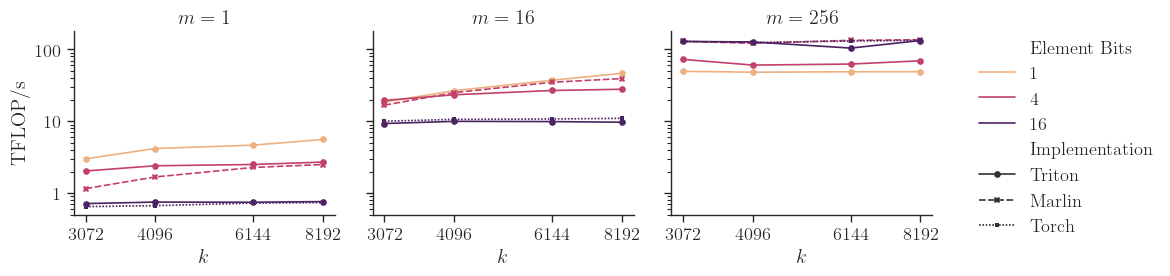

In [125]:
d = (df
    .pipe(lambda d: d[~d.impl.isin(["torch.compile", "torch.compile:unscaled"])])
    .pipe(lambda d: d[d.element_bits.isin([1, 4, 16])])
    .pipe(lambda d: d[d.m.isin([1, 16, 256])])
)

print("Relative 2*stderr mean", 2 * (d.tflops_stderr / d.tflops).mean())
print("Relative 2*stderr max", 2 * (d.tflops_stderr / d.tflops).max())

g = sns.relplot(
    data=d,
    y="tflops", x="k", col="m",
    style="impl", style_order=["Triton", "Marlin", "Torch"],
    hue="element_bits", hue_norm=matplotlib.colors.LogNorm(), palette=plot_utils.SEQ_PALETTE,
    kind="line", markers=True, height=3, aspect=0.9, mew=0,
)
for ax in g.axes.flatten():
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter("{x:.0f}")
    ax.set_xticks([3072, 4096, 6144, 8192])
    ax.set_yscale("log")
    ax.yaxis.set_major_formatter("{x:.0f}")

for m, ax in g.axes_dict.items():
    ax.set_title(f"$m={m}$")
g.figure.legend(
    handles=g.legend.legend_handles,
    labels=[text.get_text() for text in g.legend.get_texts()],
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)
g.legend.remove()

plot_utils.tidy(g.figure)
plot_utils.save("perf_micro_m_k_bits_impl")

## `tables/perf_micro_m1_impl`

In [128]:
d = (df
    .pipe(lambda d: d[~d.impl.isin(["torch.compile:unscaled"])])
    .pipe(lambda d: d[d.element_bits.isin([1, 4, 16])])
    .pipe(lambda d: d[d.m == 1])
    .pipe(lambda d: d[d.k == 8192])
    .pipe(lambda d: d.assign(speedup_ratio=lambda d: d[d.impl=="Torch"].iloc[0].avg_time / d.avg_time))
    .pipe(lambda d: d.assign(theoretical_speedup_ratio=lambda d: d[d.impl=="Torch"].iloc[0].bytes_rw / d.bytes_rw))
    .pipe(lambda d: d.assign(avg_time_str=d.apply(lambda s: f"${s.avg_time*1e6:.1f}\\,\\mathrm{{\\upmu s}}$ (${s.speedup_ratio:.1f}\\times$)", axis=1)))
    .pipe(lambda d: d.assign(gb_s_str=d.gb_s.apply(lambda x: f"${x:.0f}\\,\\mathrm{{GB/s}}$")))
    .pipe(lambda d: d.assign(avg_time_stderr_str=d.avg_time_stderr.apply(lambda s: f"${s*1e6:.2f}\\,\\mathrm{{\\upmu s}}$")))
    .sort_values(["element_bits", "avg_time"], ascending=False)
)

display(d[["element_bits", "impl", "avg_time", "avg_time_stderr", "speedup_ratio", "theoretical_speedup_ratio", "gb_s"]]
    .style.format(dict(avg_time=lambda x: f"{x*1e6:.1f} us", gb_s="{:.0f} GB/s", avg_time_stderr="{:.1e}")).hide())

cols = dict(element_bits="", impl="", avg_time_str="Time (Speedup)", gb_s_str="Effective Bandwidth")
align = "rlrr"
print(plot_utils.fmt_latex_booktabs(d, cols=cols, align=align))
plot_utils.save_table("perf_micro_m1_impl", d, cols=cols, align=align)

element_bits,impl,avg_time,avg_time_stderr,speedup_ratio,theoretical_speedup_ratio,gb_s
16,Torch,181.6 us,2.1e-08,1.000000,1.000000,739 GB/s
16,Triton,175.6 us,1.9e-08,1.033910,1.000000,764 GB/s
4,torch.compile,772.3 us,5.7e-07,0.235145,3.762167,46 GB/s
4,Marlin,53.5 us,3.2e-08,3.391979,3.762167,667 GB/s
4,Triton,49.5 us,8.0e-09,3.666746,3.762167,721 GB/s
1,torch.compile,770.4 us,3.3e-07,0.235719,12.763240,14 GB/s
1,Triton,24.0 us,1.4e-07,7.563547,12.763240,438 GB/s


\begin{tabular}{rlrr} \toprule
  Element Bits & Implementation & Time (Speedup) & Effective Bandwidth \\\midrule
  $16$ & Torch & $181.6\,\mathrm{\upmu s}$ ($1.0\times$) & $739\,\mathrm{GB/s}$ \\
  $16$ & Triton & $175.6\,\mathrm{\upmu s}$ ($1.0\times$) & $764\,\mathrm{GB/s}$ \\
  $4$ & torch.compile & $772.3\,\mathrm{\upmu s}$ ($0.2\times$) & $46\,\mathrm{GB/s}$ \\
  $4$ & Marlin & $53.5\,\mathrm{\upmu s}$ ($3.4\times$) & $667\,\mathrm{GB/s}$ \\
  $4$ & Triton & $49.5\,\mathrm{\upmu s}$ ($3.7\times$) & $721\,\mathrm{GB/s}$ \\
  $1$ & torch.compile & $770.4\,\mathrm{\upmu s}$ ($0.2\times$) & $14\,\mathrm{GB/s}$ \\
  $1$ & Triton & $24.0\,\mathrm{\upmu s}$ ($7.6\times$) & $438\,\mathrm{GB/s}$ \\
\bottomrule
\end{tabular}


remote: Updating references: 100% (1/1)           


# Model benchmarks

In [2]:
df = pd.read_json("../out/l40s-models-2026-01-20T14-17-30.jsonl", lines=True)

print("torch_version", *df.torch_version.unique())
print("cuda_version", *df.cuda_version.unique())
print("triton_version", *df.triton_version.unique())
print("device", *df.device.unique())
print("reps", *df.reps.unique())
print("block_size", *df.block_size.unique())
print()
assert len(df.commit.unique()) == 1
assert all(df.model.apply(lambda s: s.startswith("custom-llama-")))

df = df.drop(columns=[
    "reps", "id", "device", "cuda_version", "torch_version", "triton_version", "block_size",
    "output", "commit",
])
df["model"] = df["model"].apply(lambda s: s.replace("custom-llama-", ""))
df = df.rename(columns=dict(bits="element_bits"))
print("Dropping", sum(~df.error.isna()), "runs with errors")
df = df[df.error.isna()].drop(columns=["error"])
df["impl"] = df["kernel"].fillna("torch").apply(lambda k: {
    "marlin": "Marlin (Linear)", "marlin-lut": "Marlin",
    "torch": "Torch", "triton": "Triton", "torch.compile": "torch.compile",
}[k])
df = df.drop(columns=["kernel"])
df["element_bits"] = df["element_bits"].fillna(16).astype(int)

df["tokens_s"] = df["batch_size"] / df["avg_time"]
df["tokens_s_stderr"] = df["batch_size"] * df["avg_time_stderr"] / df["avg_time"]**2
df["gb_s"] = df["bytes_rw"] / df["avg_time"] / 1e9
df["tflops"] = df["ops"] / df["avg_time"] / 1e12

assert df.groupby(["model", "batch_size", "element_bits", "impl"]).count().avg_time.max() == 1

display(df.head())

torch_version 2.9.1+cu128
cuda_version 12.8
triton_version 3.5.1
device NVIDIA L40S
reps 100
block_size nan 64.0

Dropping 5 runs with errors


,model,batch_size,parameters,bytes_rw,ops,avg_time,avg_time_stderr,element_bits,impl,tokens_s,tokens_s_stderr,gb_s,tflops
0,4B,1,3.883552e+09,6.979099e+09,7.767103e+09,0.011257,2.438607e-07,16,Torch,88.833414,0.001924,619.977158,0.689978
1,4B,1,3.883552e+09,1.854044e+09,7.767103e+09,0.004505,9.657366e-06,4,Triton,221.979755,0.475867,411.560268,1.724140
2,4B,1,3.883552e+09,1.854044e+09,7.767103e+09,0.005793,3.458237e-07,4,Marlin,172.624319,0.010305,320.053111,1.340791
3,4B,1,3.883552e+09,1.854044e+09,7.767103e+09,0.005590,2.768487e-07,4,Marlin (Linear),178.879218,0.008859,331.649969,1.389373
4,4B,1,3.883552e+09,1.854044e+09,7.767103e+09,0.006145,4.591479e-06,4,torch.compile,162.726273,0.121582,301.701695,1.263912


## `perf_model_params_m_bits_impl`

Relative 2*stderr mean 0.0008752680132551767
Relative 2*stderr max 0.004287479551349055


remote: Updating references: 100% (1/1)           


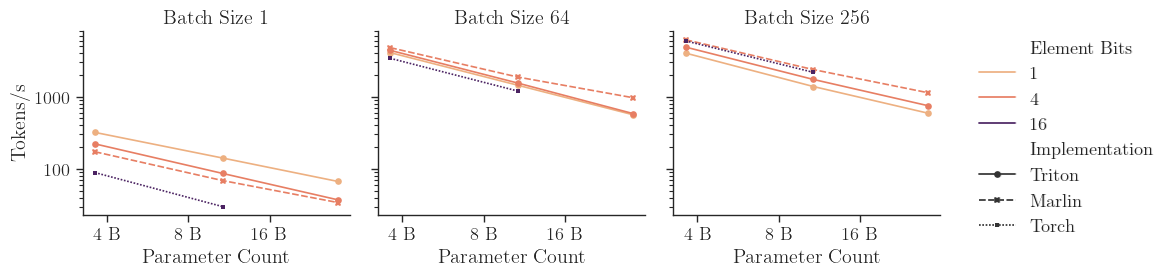

In [5]:
d = (df
    .pipe(lambda d: d[~d.impl.isin(["torch.compile", "Marlin (Linear)"])])
    .pipe(lambda d: d[d.batch_size.isin([1, 64, 256])])
)
print("Relative 2*stderr mean", 2 * (d.tokens_s_stderr / d.tokens_s).mean())
print("Relative 2*stderr max", 2 * (d.tokens_s_stderr / d.tokens_s).max())

g = sns.relplot(data=d, y="tokens_s", x="parameters", col="batch_size", hue="element_bits",
                style="impl", style_order=["Triton", "Marlin", "Torch"],
                kind="line", palette=plot_utils.SEQ_PALETTE,
                height=3, aspect=0.9, mew=0, markers=True)
for m, ax in g.axes_dict.items():
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter(lambda x, _: f"{x/2**30:.0f} B")
    ax.set_yscale("log")
    ax.yaxis.set_major_formatter("{x:.0f}")
    ax.set_title(f"Batch Size ${m}$")
g.figure.legend(
    handles=g.legend.legend_handles,
    labels=[text.get_text() for text in g.legend.get_texts()],
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)
plot_utils.tidy(g.figure)
plot_utils.save("perf_model_params_m_bits_impl")

## `tables/perf_model_m1_impl`

In [7]:
def token_s_highlighted(s: pd.Series) -> str:
    text = f"${s.tokens_s:.1f}$"
    if (s.impl, s.element_bits, s.model) in {("Torch", 16, "4B"), ("Triton", 4, "11B"), ("Triton", 1, "30B")}:
        text = f"\\color{{blue}}{{{text}}}"
    return text

d = (df
    .pipe(lambda d: d[d.batch_size==1])
    .pipe(lambda d: d[d.impl!="torch.compile"])
    .pipe(lambda d: d.assign(tokens_s_str=d.apply(token_s_highlighted, axis=1)))
)
t = (d
    .pivot(index=["element_bits", "impl"], columns="model", values="tokens_s_str")[["4B", "11B", "30B"]].reset_index()
    .pipe(lambda d: d.assign(rank=d.apply(lambda s: (-s.element_bits, ["Torch", "Triton", "Marlin", "Marlin (Linear)"].index(s.impl)), axis=1)))
    .sort_values("rank").drop(columns=["rank"])
)

print("Relative 2*stderr mean", 2 * (d.tokens_s_stderr / d.tokens_s).mean())
print("Relative 2*stderr max", 2 * (d.tokens_s_stderr / d.tokens_s).max())

display(t.style.hide())

args = dict(cols={k: "" for k in ["element_bits", "impl", "4B", "11B", "30B"]},
            align="rlrrr", nan_str="OOM")
print(plot_utils.fmt_latex_booktabs(t, **args))
plot_utils.save_table("perf_model_m1_impl", t, **args)

Relative 2*stderr mean 0.0009038341434648164
Relative 2*stderr max 0.004287479551349055


element_bits,impl,4B,11B,30B
16,Torch,\color{blue}{$88.8$},$30.0$,nan
4,Triton,$222.0$,\color{blue}{$86.4$},$37.3$
4,Marlin,$172.6$,$68.8$,$34.2$
4,Marlin (Linear),$178.9$,$70.4$,$34.8$
1,Triton,$320.1$,$141.2$,\color{blue}{$67.1$}


\begin{tabular}{rlrrr} \toprule
  Element Bits & Implementation & 4B & 11B & 30B \\\midrule
  $16$ & Torch & \color{blue}{$88.8$} & $30.0$ & OOM \\
  $4$ & Triton & $222.0$ & \color{blue}{$86.4$} & $37.3$ \\
  $4$ & Marlin & $172.6$ & $68.8$ & $34.2$ \\
  $4$ & Marlin (Linear) & $178.9$ & $70.4$ & $34.8$ \\
  $1$ & Triton & $320.1$ & $141.2$ & \color{blue}{$67.1$} \\
\bottomrule
\end{tabular}


remote: Updating references: 100% (1/1)           
